# Sentiment Analysis with RoBERTa
### Predicting whether Amazon reviews are positive, negative, or neutral
This notebook uses RoBERTa and NLTK to classify and visualize Amazon product reviews. Performs sentiment analysis on product reviews using both traditional NLP (NLTK) and transformer-based deep learning (RoBERTa). Visualizes and evaluates model predictions against user star ratings.

## 1. Core Library Imports

In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## 2. Load Data

In [2]:
# Import the data
reviews = pd.read_excel('SampleReviews.xlsx')
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## 3. Initial NLTK Exploration
Tokenize, POS-tag, and named entity recognition on a sample review.

In [3]:
# NLTK initialization
import nltk

example = reviews['Text'][26]
tokens = nltk.word_tokenize(example)
tagged = nltk.pos_tag(tokens)
chunked = nltk.chunk.ne_chunk(tagged)
print("Sample review text:", example)

Sample review text: The candy is just red , No flavor . Just  plan and chewy .  I would never buy them again


## 4. Sentiment Analysis with RoBERTa

In [4]:
from tqdm import tqdm
from scipy.special import softmax
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

In [5]:
# RoBERTa initialization
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [6]:
# Function to get sentiment scores for a single review
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return {
        "roberta_neg": scores[0],
        "roberta_neu": scores[1],
        "roberta_pos": scores[2]
    }

In [7]:
# Function to classify review sentiment
def get_sentiment(row):
    if row['roberta_neg'] > row['roberta_pos'] and row['roberta_neg'] > row['roberta_neu']:
        return 'Negative'
    if row['roberta_pos'] > row['roberta_neg'] and row['roberta_pos'] > row['roberta_neu']:
        return 'Positive'
    if row['roberta_neu'] > row['roberta_pos'] and row['roberta_neu'] > row['roberta_neg']:
        return 'Neutral'
    else:
        return 'Uh oh'

In [9]:
# Analyze all reviews
results = {}
for i, row in tqdm(reviews.iterrows(), total=len(reviews)):
    try:
        text = str(row['Text']) # Make sure everything is a string
        myid = row['Id']
        results[myid] = polarity_scores_roberta(text)
    except RuntimeError:
        print(f"Error processing id {myid}")

  0%|          | 0/25478 [00:00<?, ?it/s]

100%|██████████| 25478/25478 [28:24<00:00, 14.94it/s] 


In [11]:
# Create DataFrame for RoBERTa results
roberta = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Id'})
roberta = roberta.merge(reviews, how='left')
roberta['sentiment'] = roberta.apply(get_sentiment, axis=1)

In [13]:
roberta.head()

,Id,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,1,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,2,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,3,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,4,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Positive
4,5,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive


## 5. Visualizations of Scores and Classifications

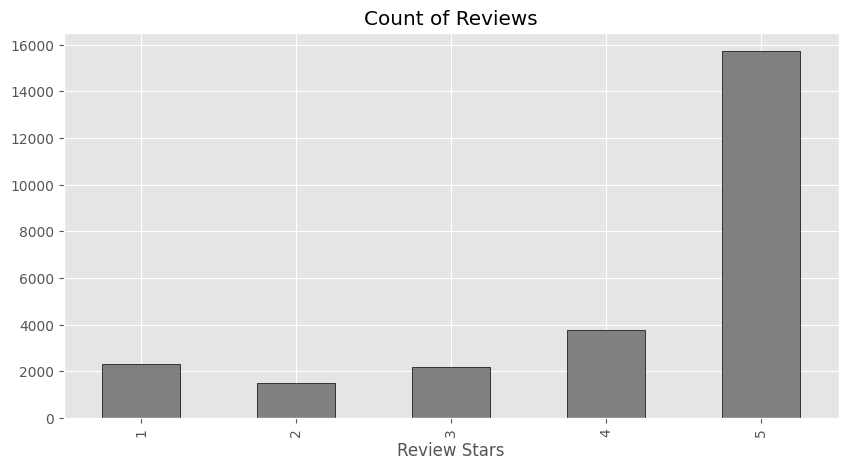

In [15]:
import seaborn as sns

score_plot = roberta['Score'].value_counts().sort_index().plot(
    kind='bar',
    title='Count of Reviews',
    figsize=(10,5),
    color='gray',
    edgecolor='black'
)
score_plot.set_xlabel('Review Stars')
plt.show()

We can see that the reviews trend heavily towards 5-star reviews. As such, we would expect that the sentiment scores we got from RoBERTa should be overwhelmingly positive as well. Let's look at a pie chart of sentiment classification.

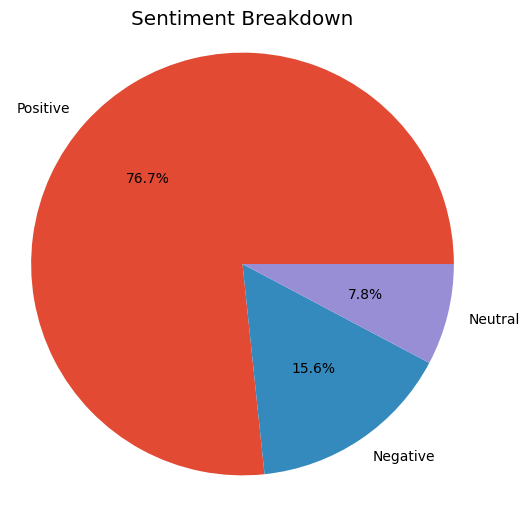

In [18]:
from matplotlib import pyplot as plt

sentiment_counts = roberta['sentiment'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Sentiment Breakdown')
plt.show()

Sentiment lines up pretty well with what we saw in the review scores. Now let's use a wordcloud to get a sense of what types of things people were saying.

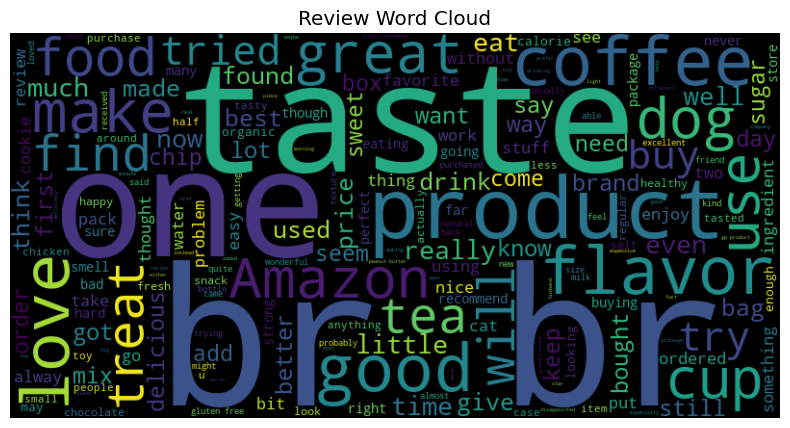

In [19]:
from wordcloud import WordCloud

text_all = ' '.join(roberta['Text'].astype(str))
wordcloud = WordCloud(width=800, height=400).generate(text_all)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Review Word Cloud')
plt.show()

## 6. Model Evaluation
Confusion Matrix: Comparing RoBERTa sentiment predictions with actual review stars.

In [21]:
from sklearn.metrics import confusion_matrix

predicted = roberta['sentiment']
actual = roberta['Score'].apply(lambda x: 'Positive' if x >= 4 else 'Negative' if x <= 2 else 'Neutral')
classes = sorted(roberta['sentiment'].unique())
confusion_mat = confusion_matrix(actual, predicted, labels=classes)
print("Confusion Matrix:\n", confusion_mat)

Confusion Matrix:
 [[ 2759   524   518]
 [  694   478  1016]
 [  518   973 17998]]


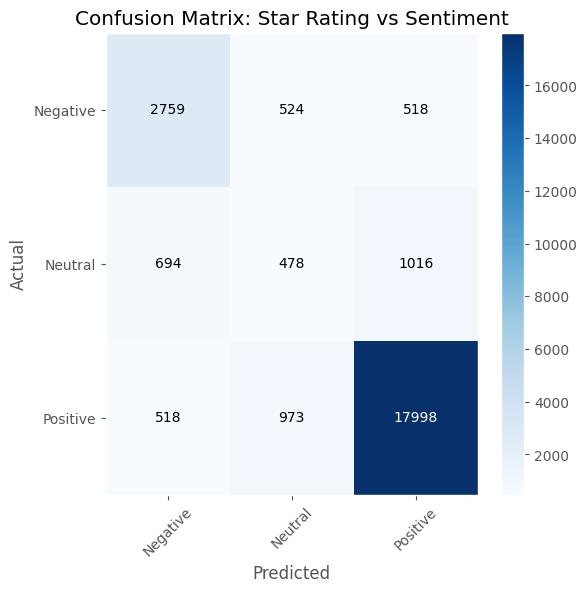

In [23]:
# Visualize confusion matrix
plt.figure(figsize=(6,6))
plt.imshow(confusion_mat, cmap='Blues', aspect='auto')
plt.grid(False)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = confusion_mat.max() / 2
for i in range(len(classes)):
    for j in range(len(classes)):
        color = 'white' if confusion_mat[i, j] > thresh else 'black'
        plt.text(j, i, confusion_mat[i, j], ha='center', va='center', color=color)
plt.title('Confusion Matrix: Star Rating vs Sentiment')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Now let's look at overall accuracy by taking the correct predictions with np.trace() and dividing them by the total number of predictions.

In [24]:
accuracy = np.trace(confusion_mat) / confusion_mat.sum()
print('Model Accuracy:', accuracy)

Model Accuracy: 0.8334641651621006


## 7. Conclusion
The RoBERTa-based sentiment analysis model classified customer reviews as Positive, Neutral, or Negative with an accuracy of 83.3%. The model effectively captures overall sentiment trends, correctly identifying the majority of reviews. While performance is strong, future improvements could focus on better handling neutral or ambiguous cases through fine-tuning or feature enhancements.